Drive Connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Mounted at / content / drive

Mounted at /content/drive


In [ ]:
!pip install earthpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 9.8 MB/s 
     |████████████████████████████████| 1.0 MB 47.2 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 16.7 MB 612 kB/s 
     |████████████████████████████████| 6.3 MB 48.6 MB/s 


In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Required Libraries İmport and array with R-G-B bands

In [ ]:
import gdal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from osgeo import gdal
import rasterio
from skimage import data, color
from skimage.transform import rescale, resize
from skimage import io, transform, exposure
from matplotlib.pyplot import imread, imshow, show, subplot, title, get_cmap, hist
from skimage.exposure import equalize_hist
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import rasterio as rio

file_list = ['/content/drive/MyDrive/image_B1.tif', '/content/drive/MyDrive/image_B2.tif', '/content/drive/MyDrive/image_B3.tif']

array_list = []

Read arrays, Geo Transform & Projection

In [ ]:
for file in file_list:
    src = gdal.Open(file)
    geotransform = src.GetGeoTransform() # Could be done more elegantly outside the for loop
    projection = src.GetProjectionRef()
    array_list.append(src.ReadAsArray())
    src = None

In [ ]:
print(geotransform)

(29.243207931518555, -0.00017610896713631322, -4.450376508164621e-05, 41.020591735839844, 2.7524922585040607e-05, -0.00013247210566296602)


Stack Arrays

In [ ]:
stacked_array = np.stack(array_list, axis=0)
array_list = None

R G B Bands

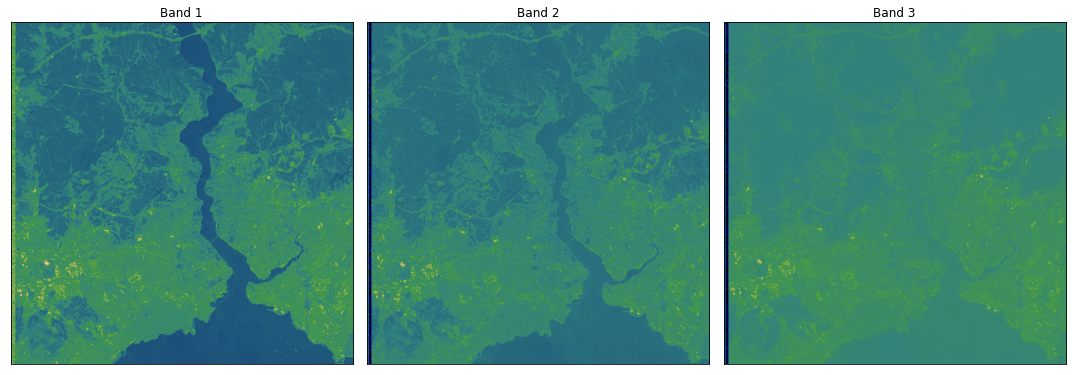

In [ ]:
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio

import matplotlib.pyplot as plt
ep.plot_bands(stacked_array, 
              cmap = 'gist_earth', 
              figsize = (15,15), 
              cols = 3, 
              cbar = False)
plt.show()

RGB image

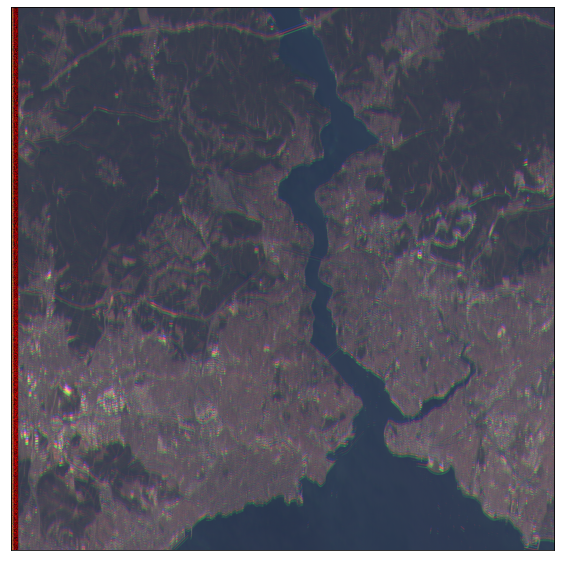

In [ ]:
# RGB Composite Image
rgb = ep.plot_rgb(stacked_array)
plt.show()

Write to disk

In [ ]:
driver = gdal.GetDriverByName('GTiff')
n, rows, cols = stacked_array.shape
dataset = driver.Create('output_file_name.tiff', cols, rows, n,
                                )
dataset.SetGeoTransform(geotransform)
dataset.SetProjection(projection)

for b in range(1,n+1):
    band = dataset.GetRasterBand(b) # GetRasterBand is not zero indexed
    band.WriteArray(stacked_array[b-1]) # Numpy is zero indexed

Histogram for each color

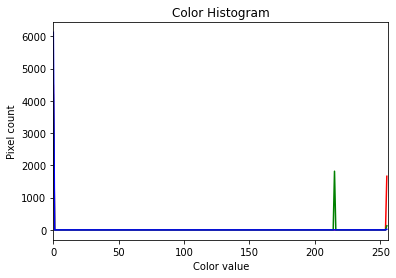

In [ ]:
colors = ("red", "green", "blue")
channel_ids = (2, 1, 0)

# create the histogram plot, with three lines, one for each color
plt.figure()
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        stacked_array[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.title("Color Histogram")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

plt.show()

import image - Clip and Save

<Figure size 432x288 with 0 Axes>

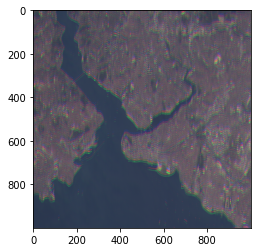

In [ ]:
img_path = '/content/drive/MyDrive/output_file_name.tif'
img = plt.imread(img_path)
imgClip = img[1000:2000, 1000:2000]
plt.figure()
plt.show()
plt.imshow(imgClip)
io.imsave('/content/drive/MyDrive/rasat_clip.tif',imgClip)

Histogram & Histogram Equalize for Clipped Image

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


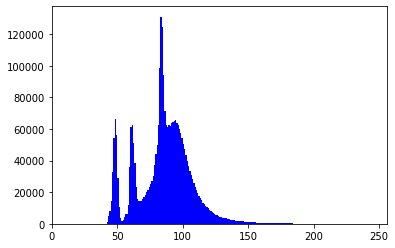

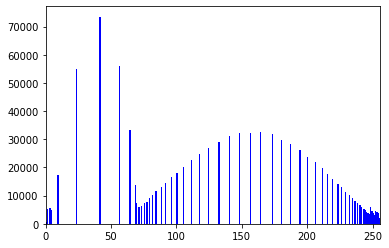

In [ ]:
grayimg=cv2.cvtColor(imgClip,cv2.COLOR_BGR2GRAY)
equ = cv2.equalizeHist(grayimg)
eq = equalize_hist(imgClip)
hist,bins = np.histogram(imgClip.flatten(),256,[0,256])
plt.hist(imgClip.flatten(),256,[0,256], color = 'b')
plt.xlim([0,256])
plt.show()
hist,bins = np.histogram(equ.flatten(),256,[0,256])
plt.hist(equ.flatten(),256,[0,256], color = 'b')
plt.xlim([0,256])
plt.show()

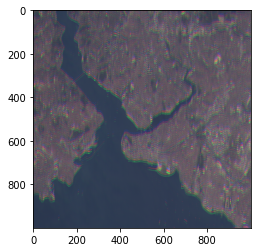

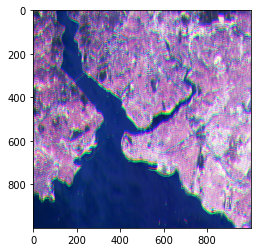

(2048, 2048, 3)


In [ ]:
plt.imshow(imgClip)
plt.show()
plt.imshow(eq)
plt.show()
print(img.shape)

Pan Band Importing & resized & clip

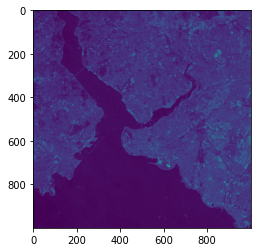

In [ ]:
from skimage import io, transform, exposure
panBand = plt.imread('/content/drive/MyDrive/image.tif')

image_resized = resize(panBand, (2048,2048),
                       anti_aliasing=True)
panClip = image_resized[1000:2000, 1000:2000]
plt.show()
plt.imshow(panClip)
io.imsave('/content/drive/MyDrive/rasatpan_clip.tif',panClip)

In [ ]:
!pip install imagecodecs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.0 MB 1.7 MB/s 


Pansharpening

In [ ]:
import gc
def pansharpen(m, pan, psh, R = 3, G = 2, B = 1, method = 'simple_brovey', W = 0.1):

  
    with rasterio.open(m) as f:
        metadata_ms = f.profile
        img_ms = np.transpose(f.read(tuple(np.arange(metadata_ms['count']) + 1)), [1, 2, 0])
    
    with rasterio.open(pan) as g:
        metadata_pan = g.profile
        img_pan = g.read(1)
    

  
    ms_to_pan_ratio = metadata_ms['transform'][0] / metadata_pan['transform'][0]
    rescaled_ms = cv2.resize(img_ms, dsize = None, fx = ms_to_pan_ratio, fy = ms_to_pan_ratio, 
                             interpolation=cv2.INTER_CUBIC).astype(metadata_ms['dtype'])  

  
    if img_pan.shape[0] < rescaled_ms.shape[0]:
        ms_row_bigger = True
        rescaled_ms = rescaled_ms[: img_pan.shape[0], :, :]
    else:
        ms_row_bigger = False
        img_pan = img_pan[: rescaled_ms.shape[0], :]
        
    if img_pan.shape[1] < rescaled_ms.shape[1]:
        ms_column_bigger = True
        rescaled_ms = rescaled_ms[:, : img_pan.shape[1], :]
    else:
        ms_column_bigger = False
        img_pan = img_pan[:, : rescaled_ms.shape[1]]
  
    del img_ms; gc.collect()
  
  
    if ms_row_bigger == True and ms_column_bigger == True:
        img_psh = np.zeros((img_pan.shape[0], img_pan.shape[1], rescaled_ms.shape[2]), dtype = metadata_pan['dtype'])
    elif ms_row_bigger == False and ms_column_bigger == True:
        img_psh = np.zeros((rescaled_ms.shape[0], img_pan.shape[1], rescaled_ms.shape[2]), dtype = metadata_pan['dtype'])
        metadata_pan['height'] = rescaled_ms.shape[0]
    elif ms_row_bigger == True and ms_column_bigger == False:
        img_psh = np.zeros((img_pan.shape[0], rescaled_ms.shape[1], rescaled_ms.shape[2]), dtype = metadata_pan['dtype'])
        metadata_pan['width'] = rescaled_ms.shape[1]
    else:
        img_psh = np.zeros((rescaled_ms.shape), dtype = metadata_pan['dtype'])
        metadata_pan['height'] = rescaled_ms.shape[0]
        metadata_pan['width'] = rescaled_ms.shape[1]
    

    
    if method == 'simple_brovey':
        all_in = rescaled_ms[:, :, R - 1] + rescaled_ms[:, :, G - 1] + rescaled_ms[:, :, B - 1] + rescaled_ms[:, :, 0 - 1]
        for band in range(rescaled_ms.shape[2]):
            img_psh[:, :, band] = np.multiply(rescaled_ms[:, :, band], (img_pan / all_in))
      
  
    if method == 'simple_mean':
        for band in range(rescaled_ms.shape[2]):
            img_psh[:, :, band] = 0.5 * (rescaled_ms[:, :, band] + img_pan)
    
        
    if method == 'esri':
        ADJ = img_pan - rescaled_ms.mean(axis = 2)
        for band in range(rescaled_ms.shape[2]):
            img_psh[:, :, band] = rescaled_ms[:, :, band] + ADJ
        
    
    if method == 'brovey':
        DNF = (img_pan - W * rescaled_ms[:, :, 0 - 1]) / (W * rescaled_ms[:, :, R - 1] + W * rescaled_ms[:, :, G - 1] + W * rescaled_ms[:, :, B - 1])
        for band in range(rescaled_ms.shape[2]):
            img_psh[:, :, band] = rescaled_ms[:, :, band] * DNF
        
  
    del img_pan, rescaled_ms; gc.collect()
  
    
    metadata_pan['count'] = img_psh.shape[2]
    with rasterio.open(psh, 'w', **metadata_pan) as dst:
        dst.write(np.transpose(img_psh, [2, 0, 1]))
  
    return img_psh

In [ ]:
m = '/content/drive/MyDrive/rasat_clip.tif'
pan = '/content/drive/MyDrive/rasatpan_clip.tif'
psh = '/content/smp_bro.tif'
R =3 
G=2
B=1
method = 'brovey'
W = 0.1
pansharpen(m, pan, psh, R = 3, G = 2, B = 1, method = 'simple_brovey', W = 0.1)

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:236: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  **kwargs)


array([[[ 0.19578246,  0.21753607,  0.27347392],
        [ 0.20363636,  0.21262032,  0.25754011],
        [ 0.2025641 ,  0.17948718,  0.22051282],
        ...,
        [ 0.19356271,  0.15323714,  0.19154643],
        [ 0.20929313,  0.15336134,  0.15696985],
        [ 0.20833745,  0.16343714,  0.15086505]],

       [[ 0.20064171,  0.22160428,  0.25454545],
        [ 0.17866401,  0.20937188,  0.24566301],
        [ 0.18588235,  0.16705882,  0.20705882],
        ...,
        [ 0.20196078,  0.16240146,  0.18530422],
        [ 0.19264287,  0.16287079,  0.1488604 ],
        [ 0.18578057,  0.155351  ,  0.13933543]],

       [[ 0.17613636,  0.14962121,  0.16287879],
        [ 0.2027027 ,  0.15765766,  0.19144144],
        [ 0.20398482,  0.18766603,  0.23662239],
        ...,
        [ 0.17317647,  0.16188235,  0.16752941],
        [ 0.17047152,  0.14544818,  0.1407563 ],
        [ 0.18277801,  0.13413547,  0.13560949]],

       ...,

       [[ 2.96470588,  3.95294118,  5.64705882],
        [ 6

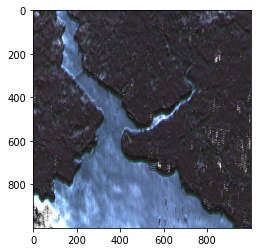

In [ ]:
pans = io.imread('/content/smp_bro.tif')
plt.show()
plt.imshow(pans)

(-0.5, 999.5, 999.5, -0.5)

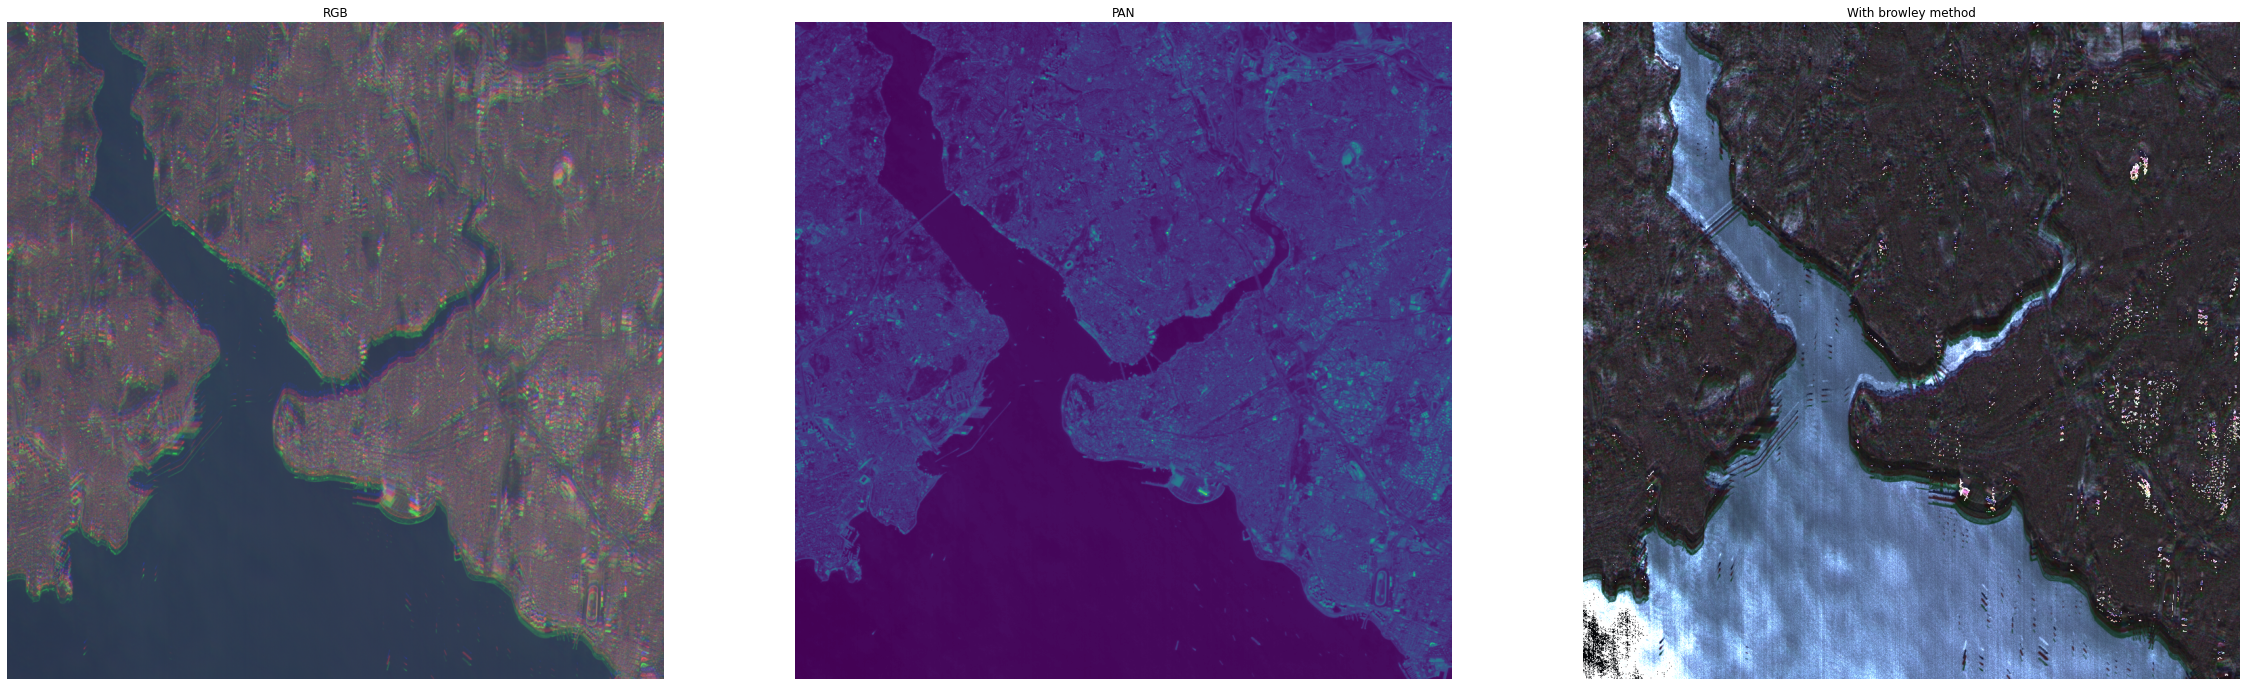

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(40, 40))
ax[0].imshow(imgClip[:,:,:])
ax[0].set_title('RGB')
ax[0].axis('off')

ax[1].imshow(panClip[:,:])
ax[1].set_title('PAN')
ax[1].axis('off')

ax[2].imshow(pans[:,:,:3])
ax[2].set_title('With browley method')
ax[2].axis('off')
